<a href="https://colab.research.google.com/github/andrejobuljen/ML_projects/blob/main/JAX/jax_mlp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import vmap, grad, jit, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

## Load MNIST data and visualize it


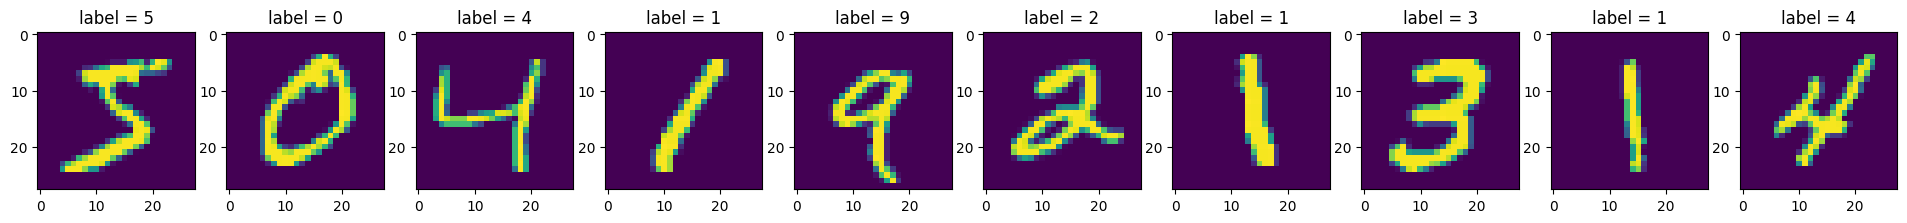

In [29]:
mnist_img_size = (28,28)

def transform_mnist(x):
  return np.ravel(np.array(x, dtype=np.float32))

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=transform_mnist)
test_dataset  = MNIST(root='test_mnist', train=False, download=True, transform=transform_mnist)

fig, ax = plt.subplots(1, 10, figsize=(24,4))
for i, axi in enumerate(ax):
  axi.imshow(train_dataset[i][0].reshape(mnist_img_size))
  axi.set_title('label = %i'%train_dataset[i][1])

## Initialize Multi-Layer Perceptron (MLP)

In [30]:
def init_MLP(layer_widths, parent_key, scale=0.01):
  """
  Args:
    layer_widths: number of neurons in each layer
    parent_key: jax random PRNGKey
    scale: scale the standard deviation when setting the weights (default 0.01)

  Returns:
    params: weigths and biasses
  """

  params = []
  keys = jax.random.split(parent_key, num=len(layer_widths)-1)

  for in_width, out_width, key  in zip(layer_widths[:-1], layer_widths[1:], keys):
    weight_key, bias_key = jax.random.split(key)
    params.append([
        scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
        scale*jax.random.normal(bias_key, shape=(out_width,))
        ]
    )
  return params

seed = 0
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


<ipython-input-30-9c29184a194a>:27: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print(jax.tree_map(lambda x: x.shape, MLP_params))


In [31]:
def MLP_predict(params, x):
  """

  Args:
    params: weigts and biasses
    x: image

  Returns:
    cross entropy loss

  """

  activation = x

  for w, b in params[:-1]:
    activation = jax.nn.relu(jnp.dot(w, activation) + b)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last, activation) + b_last

  return logits - logsumexp(logits)

# test single random image

test_img_flat = np.random.randn(np.prod(mnist_img_size))
print (test_img_flat.shape)

test_prediction = MLP_predict(MLP_params, test_img_flat)
print (test_prediction.shape)

batched_MLP_predict = vmap(MLP_predict, in_axes=(None,0))

# test on batched random images
test_imgs_flat = np.random.randn(10, np.prod(mnist_img_size))
print (test_imgs_flat.shape)

test_predictions = batched_MLP_predict(MLP_params, test_imgs_flat)
print (test_predictions.shape)


(784,)
(10,)
(10, 784)
(10, 10)


In [32]:
def custom_collate_fn(batch):

   transposed_data = list(zip(*batch))
   images = np.array(transposed_data[0])
   labels = np.array(transposed_data[1])

   return images, labels

# Choose a batch size
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# load train and test images and labels into memory
train_imgs = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_imgs = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [40]:
@jit
def update(params, imgs, gt_lbls, lr=1e-3):

  loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

  return loss, jax.tree.map(lambda p, g: p-lr*g, params, grads)

def loss_fn(params, imgs, gt_lbls):

  predictions = batched_MLP_predict(params, imgs)

  return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):

  pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)

  return jnp.mean(pred_classes == dataset_lbls)


num_epochs = 20 # number of epochs
MLP_params = init_MLP([784, 512, 256, 10], key) # initialize MLP_params
train_loss, test_loss = [], []
train_acc, test_acc = [], []
gt_labels_test = jax.nn.one_hot(test_lbls, len(MNIST.classes))

for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0
  num_batches = 0

  for batch_id, (imgs, lbls) in enumerate(train_loader):

    gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))

    loss, MLP_params = update(MLP_params, imgs, gt_labels)

    # if batch_id % 50 ==0:
      # print (loss)

    epoch_loss  += loss
    num_batches += 1

  train_loss.append(epoch_loss/num_batches)

  # Compute the loss on the test data
  test_loss_value = loss_fn(MLP_params, test_imgs, gt_labels_test)
  test_loss.append(test_loss_value)

  train_acc.append(accuracy(MLP_params, train_imgs, train_lbls))
  test_acc.append(accuracy(MLP_params, test_imgs, test_lbls))

  print ('Epoch %i, train acc = %.4f, test accuracy = %.4f, train loss = %.4f, test loss = %.4f'\
                %(epoch, train_acc[-1], test_acc[-1], train_loss[-1], test_loss[-1]))

  5%|▌         | 1/20 [00:13<04:07, 13.02s/it]

Epoch 0, train acc = 0.8040, test accuracy = 0.8156, train loss = 0.1579, test loss = 0.0964


 10%|█         | 2/20 [00:23<03:26, 11.49s/it]

Epoch 1, train acc = 0.8538, test accuracy = 0.8617, train loss = 0.0753, test loss = 0.0577


 15%|█▌        | 3/20 [00:33<03:07, 11.01s/it]

Epoch 2, train acc = 0.8743, test accuracy = 0.8847, train loss = 0.0533, test loss = 0.0456


 20%|██        | 4/20 [00:43<02:47, 10.49s/it]

Epoch 3, train acc = 0.8865, test accuracy = 0.8965, train loss = 0.0446, test loss = 0.0398


 25%|██▌       | 5/20 [00:53<02:33, 10.24s/it]

Epoch 4, train acc = 0.8959, test accuracy = 0.9026, train loss = 0.0398, test loss = 0.0362


 30%|███       | 6/20 [01:03<02:23, 10.26s/it]

Epoch 5, train acc = 0.9020, test accuracy = 0.9077, train loss = 0.0367, test loss = 0.0337


 35%|███▌      | 7/20 [01:13<02:13, 10.26s/it]

Epoch 6, train acc = 0.9070, test accuracy = 0.9118, train loss = 0.0344, test loss = 0.0319


 40%|████      | 8/20 [01:22<01:58,  9.87s/it]

Epoch 7, train acc = 0.9116, test accuracy = 0.9160, train loss = 0.0326, test loss = 0.0304


 45%|████▌     | 9/20 [01:33<01:50, 10.04s/it]

Epoch 8, train acc = 0.9144, test accuracy = 0.9188, train loss = 0.0312, test loss = 0.0292


 50%|█████     | 10/20 [01:43<01:42, 10.20s/it]

Epoch 9, train acc = 0.9169, test accuracy = 0.9206, train loss = 0.0300, test loss = 0.0283


 55%|█████▌    | 11/20 [01:54<01:32, 10.28s/it]

Epoch 10, train acc = 0.9198, test accuracy = 0.9228, train loss = 0.0290, test loss = 0.0274


 60%|██████    | 12/20 [02:03<01:19,  9.91s/it]

Epoch 11, train acc = 0.9223, test accuracy = 0.9254, train loss = 0.0280, test loss = 0.0266


 65%|██████▌   | 13/20 [02:14<01:10, 10.10s/it]

Epoch 12, train acc = 0.9244, test accuracy = 0.9271, train loss = 0.0272, test loss = 0.0259


 70%|███████   | 14/20 [02:24<01:01, 10.18s/it]

Epoch 13, train acc = 0.9261, test accuracy = 0.9281, train loss = 0.0265, test loss = 0.0253


 75%|███████▌  | 15/20 [02:33<00:49,  9.95s/it]

Epoch 14, train acc = 0.9282, test accuracy = 0.9302, train loss = 0.0257, test loss = 0.0247


 80%|████████  | 16/20 [02:43<00:39,  9.97s/it]

Epoch 15, train acc = 0.9303, test accuracy = 0.9317, train loss = 0.0251, test loss = 0.0241


 85%|████████▌ | 17/20 [02:54<00:30, 10.14s/it]

Epoch 16, train acc = 0.9318, test accuracy = 0.9330, train loss = 0.0245, test loss = 0.0236


 90%|█████████ | 18/20 [03:04<00:20, 10.25s/it]

Epoch 17, train acc = 0.9332, test accuracy = 0.9344, train loss = 0.0239, test loss = 0.0232


 95%|█████████▌| 19/20 [03:13<00:09,  9.92s/it]

Epoch 18, train acc = 0.9349, test accuracy = 0.9343, train loss = 0.0234, test loss = 0.0226


100%|██████████| 20/20 [03:24<00:00, 10.21s/it]

Epoch 19, train acc = 0.9360, test accuracy = 0.9358, train loss = 0.0229, test loss = 0.0223


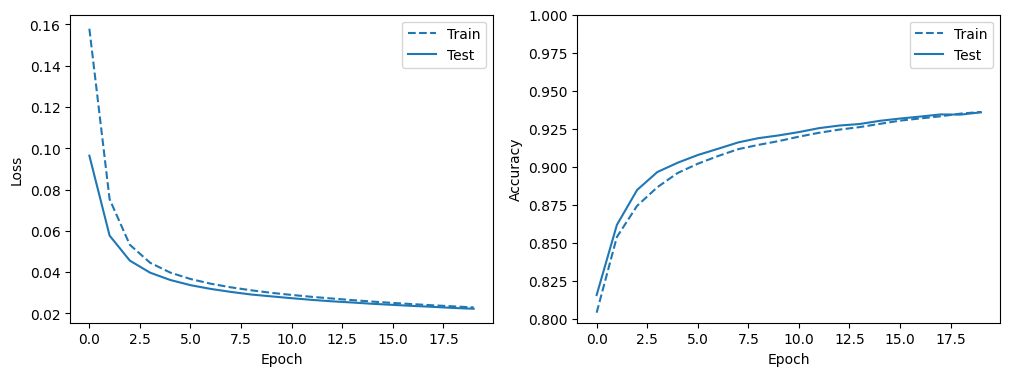

In [83]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(train_loss, 'C0--', label ='Train')
ax[0].plot(test_loss, 'C0', label = 'Test')

ax[1].plot(train_acc, 'C0--', label ='Train')
ax[1].plot(test_acc, 'C0', label = 'Test')
ax[1].set_ylim(top=1)

ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend(loc=0)
ax[1].legend(loc=0)

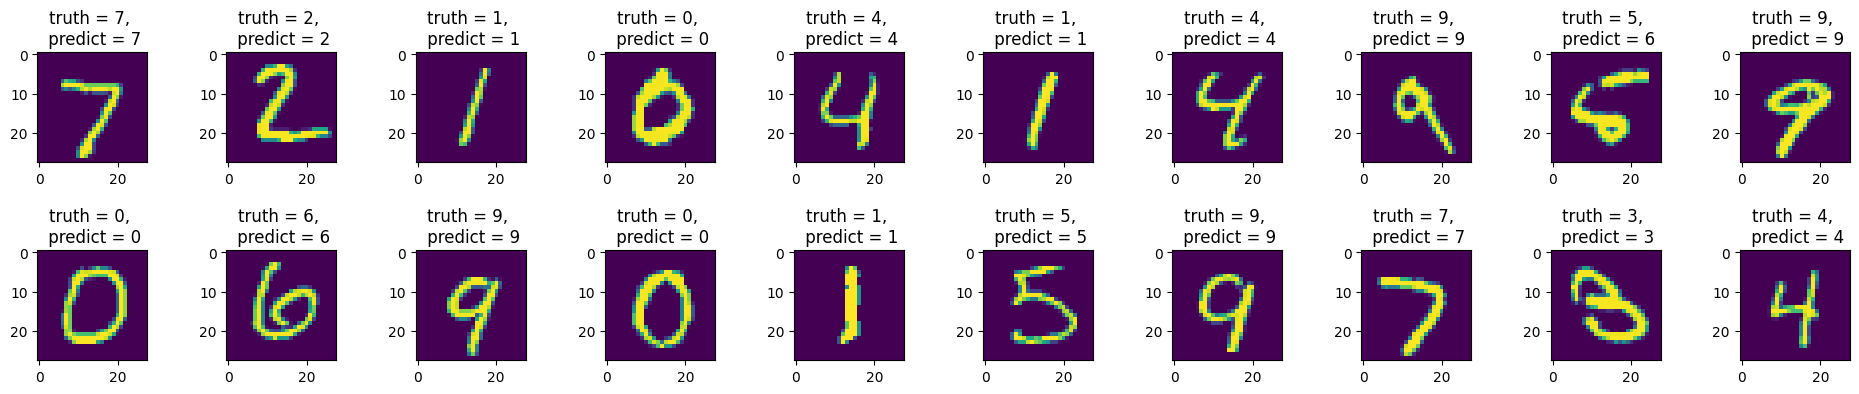

In [45]:
fig, ax = plt.subplots(2, 10, figsize=(24,4))
ax = ax.flatten()
for i, axi in enumerate(ax):
  axi.imshow(test_imgs[i].reshape(mnist_img_size))
  lbl_prediction = jnp.argmax(MLP_predict(MLP_params, np.ravel(test_imgs[i])))
  axi.set_title('truth = %i, \n predict = %i'%(test_lbls[i], lbl_prediction))
plt.subplots_adjust(hspace=0.8)

In [61]:
# w = MLP_params[0][0]
# print(w.shape)

# w_single = w[2, :].reshape(mnist_img_size)
# print(w_single.shape)
# cax = plt.imshow(w_single)
# plt.colorbar(cax)

## Embeddings using t-SNE from sklearn

(1280, 256)


<ipython-input-78-59758ab1c7fb>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')


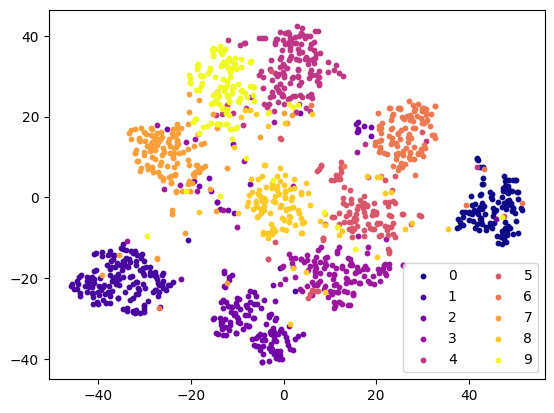

In [78]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

all_activations = []
all_lbls = []
for i, (imgs, lbls) in enumerate(test_loader):
    if i >= 10:
        break
    batch_activations = batched_fetch_activations(MLP_params, imgs)
    all_activations.append(batch_activations)
    all_lbls.append(lbls)

all_activations = jnp.concatenate(all_activations)
all_lbls = jnp.concatenate(all_lbls)
print(all_activations.shape)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(all_activations)

cmap = cm.get_cmap('plasma')
norm = plt.Normalize(all_lbls.min(), all_lbls.max())

for class_id in range(10):
  idx = (all_lbls == class_id)
  plt.scatter(t_sne_embeddings[idx, 0], t_sne_embeddings[idx, 1], s=10, color=cmap(norm(class_id)), label = '%s'%class_id)
plt.legend(loc=0, ncol=2)

## let's try embedding in 3D as well


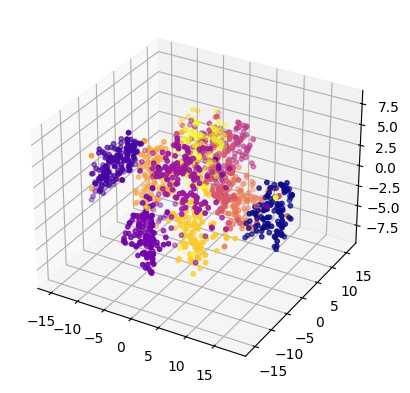

In [86]:
from mpl_toolkits.mplot3d import Axes3D

t_sne_embeddings_3D = TSNE(n_components=3, perplexity=50,).fit_transform(all_activations)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for class_id in range(10):
    idx = (all_lbls == class_id)
    ax.scatter(t_sne_embeddings_3D[idx, 0], t_sne_embeddings_3D[idx, 1], t_sne_embeddings_3D[idx, 2], s=10, color=cmap(norm(class_id)), label = '%s'%class_id)

<!-- ## Dead neurons -->